<a href="https://colab.research.google.com/github/dorota10/ML_UEP_2024/blob/CaseStudy2/CaseStudy2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

In [2]:
ratings = pd.read_csv('https://s3-us-west-2.amazonaws.com/recommender-tutorial/ratings.csv')
movies = pd.read_csv('https://s3-us-west-2.amazonaws.com/recommender-tutorial/movies.csv')

In [3]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
movies['genres'] = movies['genres'].str.split('|')
movies = movies.explode('genres')

films_scifi=len(movies[movies["genres"]=="Sci-Fi"])
print(f"W bazie znajduje się {films_scifi} filmów Sci-Fi.")

W bazie znajduje się 980 filmów Sci-Fi.


In [5]:
movies_means = ratings.groupby("movieId")["rating"].mean()
movies_means=pd.merge(movies[["movieId", "title"]], movies_means, left_on="movieId", right_on="movieId").drop_duplicates()
movies_means

,movieId,title,rating
0,1,Toy Story (1995),3.920930
5,2,Jumanji (1995),3.431818
8,3,Grumpier Old Men (1995),3.259615
10,4,Waiting to Exhale (1995),2.357143
13,5,Father of the Bride Part II (1995),3.071429
...,...,...,...
22035,193581,Black Butler: Book of the Atlantic (2017),4.000000
22039,193583,No Game No Life: Zero (2017),3.500000
22042,193585,Flint (2017),3.500000
22043,193587,Bungo Stray Dogs: Dead Apple (2018),3.500000


In [6]:
# movies_rates=pd.DataFrame(ratings.groupby("movieId")["rating"].mean())
movies_rates=pd.merge(movies[["movieId", "title", 'genres']], ratings[['movieId', 'rating']], left_on="movieId", right_on="movieId")

movies_names = movies_rates[["movieId", "title"]].drop_duplicates()
movies_names[['title', 'year']] = movies_names['title'].str.split(' \(', n=1, expand=True)
movies_names['year'] = movies_names['year'].str.rstrip(')')

#Tworzę dwa słowniki

#pierwszy słownik pozwala wyszukać id na podstawie tytułu (bez roku)
movies_dict= {row['title']: row['movieId'] for _, row in movies_names.iterrows()}
#drugi słownik pozwala wyszukać film na podstawie id
id_dict= {row['movieId']: row['title'] for _, row in movies_names.iterrows()}

In [7]:
comedy_rates=movies_rates[movies_rates["genres"]=="Comedy"][["rating"]]
comedy_rates

,rating
645,4.0
646,4.0
647,4.5
648,2.5
649,4.5
...,...
274461,3.5
274465,4.0
274471,4.0
274474,3.5


<ipython-input-8-b30ebbda5d6e>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(comedy_rates,x="rating", palette="magma")


<Axes: xlabel='rating', ylabel='count'>

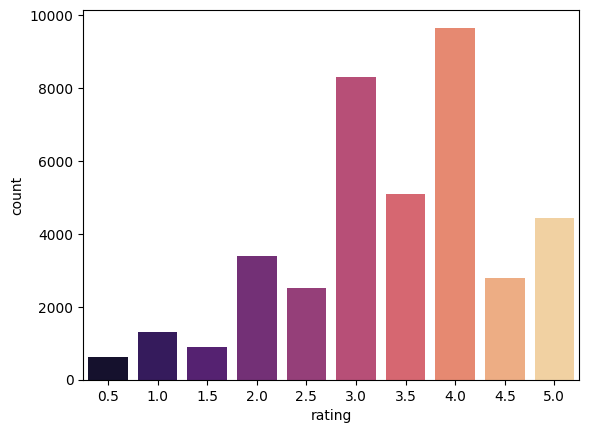

In [8]:
sns.countplot(comedy_rates,x="rating", palette="magma")

In [9]:
action_rates=movies_rates[movies_rates["genres"]=="Action"]["rating"]
action_mean=round(action_rates.mean(),2)
print(f"Średnia ocena wszystkich filmów akcji wynosi {action_mean}.")

Średnia ocena wszystkich filmów akcji wynosi 3.45.


In [10]:
action_movies=movies_rates[movies_rates["genres"]=="Action"]
action_stats=action_movies.groupby(['movieId', 'title'])['rating'].agg(["count", "mean"])
C = action_stats['count'].mean()
m = action_stats['mean'].mean()
def bayesian_avg(ratings):
    bayesian_avg = (C*m+ratings.sum())/(C+ratings.count())
    return bayesian_avg

bayesian_avg_ratings = action_movies.groupby('movieId')['rating'].agg(bayesian_avg).reset_index()
bayesian_avg_ratings.columns = ['movieId', 'bayesian_avg']
action_stats_with_bayes = action_stats.merge(bayesian_avg_ratings, on='movieId')
action_stats_with_bayes=movies_rates[['movieId',	'title']].merge(action_stats_with_bayes, on='movieId').drop_duplicates()
action_stats_with_bayes.sort_values(by="bayesian_avg", ascending=False, inplace=True)
action_stats_with_bayes

,movieId,title,count,mean,bayesian_avg
47700,2959,Fight Club (1999),218,4.272936,4.188811
6139,260,Star Wars: Episode IV - A New Hope (1977),251,4.231076,4.159938
22189,1196,Star Wars: Episode V - The Empire Strikes Back...,211,4.215640,4.133145
42200,2571,"Matrix, The (1999)",278,4.192446,4.130021
84662,58559,"Dark Knight, The (2008)",149,4.238255,4.122617
...,...,...,...,...,...
44463,2643,Superman IV: The Quest for Peace (1987),16,1.687500,2.407294
30930,1499,Anaconda (1997),27,1.925926,2.373467
35062,1882,Godzilla (1998),33,1.954545,2.338482
51982,3593,Battlefield Earth (2000),19,1.657895,2.331176


In [11]:

best_three=list(action_stats_with_bayes["title"][:3])
print(f"Najlepsze filmy akcji wg średniej bayesowskiej to \n 1. {best_three[0]}, \n 2. {best_three[1]} \n 3. {best_three[2]} ")

Najlepsze filmy akcji wg średniej bayesowskiej to 
 1. Fight Club (1999), 
 2. Star Wars: Episode IV - A New Hope (1977) 
 3. Star Wars: Episode V - The Empire Strikes Back (1980) 


In [12]:
pip install surprise

In [13]:
from surprise import Dataset, Reader
from surprise.model_selection import GridSearchCV, cross_validate
from surprise import SVD, KNNWithMeans
from surprise.prediction_algorithms import SVD, KNNBasic, KNNBaseline
from surprise.prediction_algorithms.knns import KNNWithMeans

In [14]:
min_rating = ratings.rating.min()
max_rating = ratings.rating.max()

reader = Reader(rating_scale=(min_rating, max_rating))
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

In [15]:
algo = SVD()
cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True);

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8754  0.8739  0.8780  0.8742  0.8719  0.8747  0.0020  
MAE (testset)     0.6741  0.6700  0.6746  0.6702  0.6703  0.6719  0.0021  
Fit time          2.59    4.04    4.28    3.85    3.18    3.59    0.62    
Test time         0.36    0.39    0.83    0.35    0.66    0.51    0.19    


In [23]:
param_grid_knn_means = {'k': [2, 3, 4, 5, 6]}

knn_with_means = KNNWithMeans(sim_options={'name': 'pearson_baseline', 'user_based': False}, min_support=5) #przynajmniej 5 użytkowników oceniło film

cv_knn_means = cross_validate(knn_with_means, data, measures=['RMSE'], cv=5, n_jobs=-1)

results_knn = pd.DataFrame({'k': param_grid_knn_means['k'], 'RMSE': cv_knn_means['test_rmse']})

results_knn["RMSE"].mean()

0.8831148962167017

In [24]:
import plotly.graph_objs as go
import plotly.io as pio

# Tworzenie śladu (trace) dla wykresu liniowego
trace = go.Scatter(x=results_knn['k'], y=results_knn['RMSE'], mode='lines+markers')

# Tworzenie układu (layout) dla wykresu
layout = go.Layout(xaxis=dict(title='k'),
                   yaxis=dict(title='RMSE'))

# Tworzenie wykresu
fig = go.Figure(data=[trace], layout=layout)

# Wyświetlanie wykresu
pio.show(fig)

Najleszpa liczba sąsiadów to k=4

In [25]:
trainset = data.build_full_trainset()
knn_with_means.fit(trainset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [30]:
chosen_title="Jumanji"

chosen_movie_id= movies_dict[chosen_title]

# Uzyskanie identyfikatora wewnętrznego dla filmu "Jumanji"
movie_inner_id = trainset.to_inner_iid(chosen_movie_id)

# Uzyskanie rekomendacji dla filmu "Jumanji" (identyfikator wewnętrzny)
movie_neighbors = knn_with_means.get_neighbors(movie_inner_id, k=4)

#sortowanie
best_neighbors = sorted(movie_neighbors, key=lambda x: knn_with_means.sim[movie_inner_id, x], reverse=True)

# Konwersja identyfikatorów wewnętrznych na identyfikatory zewnętrzne (nazwy filmów)
movie_neighbors_raw_ids = [knn_with_means.trainset.to_raw_iid(movie_inner_id) for movie_inner_id in best_neighbors]

# Wydrukowanie rekomendacji
print(f"Rekomendowane filmy dla filmu {chosen_title}:")
for movie_id in movie_neighbors_raw_ids:
    print(id_dict[movie_id])

Rekomendowane filmy dla filmu Jumanji:
Mrs. Doubtfire
Mask, The
Back to the Future
Liar Liar


In [27]:
movies_means[movies_means["movieId"].isin([chosen_movie_id, *movie_neighbors_raw_ids])]

,movieId,title,rating
5,2,Jumanji (1995),3.431818
698,367,"Mask, The (1994)",3.184713
931,500,Mrs. Doubtfire (1993),3.388889
2150,1270,Back to the Future (1985),4.038012


Najwyżej ocenianym filmem podobnym do "Jumanji" jest film: Back to the Future (1985).

In [31]:
chosen_title="Flint"

chosen_movie_id= movies_dict[chosen_title]

# Uzyskanie identyfikatora wewnętrznego dla filmu "Flint"
movie_inner_id = knn_with_means.trainset.to_inner_iid(chosen_movie_id)

# Uzyskanie rekomendacji dla filmu "Flint" (identyfikator wewnętrzny)
movie_neighbors = knn_with_means.get_neighbors(movie_inner_id, k=4)

# Konwersja identyfikatorów wewnętrznych na identyfikatory zewnętrzne (nazwy filmów)
movie_neighbors_raw_ids = [knn_with_means.trainset.to_raw_iid(movie_inner_id) for movie_inner_id in movie_neighbors]

# Wydrukowanie rekomendacji
print(f"Rekomendowane filmy dla filmu {chosen_title}:")
for movie_id in movie_neighbors_raw_ids:
    print(id_dict[movie_id])

Rekomendowane filmy dla filmu Flint:
Toy Story
Grumpier Old Men
Heat
Seven


In [29]:
movies_means[movies_means["movieId"].isin([chosen_movie_id, *movie_neighbors_raw_ids])]

,movieId,title,rating
0,1,Toy Story (1995),3.920930
8,3,Grumpier Old Men (1995),3.259615
14,6,Heat (1995),3.946078
22042,193585,Flint (2017),3.500000


Najwyżej ocenianym podobnym filmem do "Flint" jest kryminał: Heat(1995)